In [1]:
%matplotlib inline


# Permutation Importance with Multicollinear or Correlated Features


In this example, we compute the permutation importance on the Wisconsin
breast cancer dataset using :func:`~sklearn.inspection.permutation_importance`.
The :class:`~sklearn.ensemble.RandomForestClassifier` can easily get about 97%
accuracy on a test dataset. Because this dataset contains multicollinear
features, the permutation importance will show that none of the features are
important. One approach to handling multicollinearity is by performing
hierarchical clustering on the features' Spearman rank-order correlations,
picking a threshold, and keeping a single feature from each cluster.

<div class="alert alert-info"><h4>Note</h4><p>See also
    `sphx_glr_auto_examples_inspection_plot_permutation_importance.py`</p></div>


In [2]:
print(__doc__)
from collections import defaultdict
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

Automatically created module for IPython interactive environment


In [3]:
# path30 = r'C:\Users\yuwan\Dropbox\Zotero\attachments\Ni et al_2020_A Novel Approach to Identifying Mantle‐Equilibrated Zircon by Using Trace.xlsx'
# df = pd.read_excel(path30, header=1)
# cols = ['CITATION', 'HOSTROCKTYPE', 
#         'P', 'Ti', 'Y', 'Nb', 'La', 'Ce', 'Pr',
#        'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf',
#        'Th', 'U']
# df = df.loc[:, cols]
# X = df.copy()
# groups = X.pop('CITATION')
# y = X.pop('HOSTROCKTYPE')
# # X = np.log(X)

# data = pd.DataFrame()
# data['feature_names'] = [ 'P', 'Ti', 'Y', 'Nb', 'La', 'Ce', 'Pr',
#        'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf',
#        'Th', 'U']

In [4]:
df = pd.read_excel(r'C:\Users\yuwan\Dropbox\workspace-ol\quartz_classifier\Table S2.xlsx')
cols5 = ['qtype','Al', 'Ti', 'Li','Ge', 'Sr']
for ele in cols5[1:]:
    df[ele] = pd.to_numeric(df[ele], errors='coerce')
df5 = df.loc[: , cols5].dropna()

X = df5.drop('qtype', axis=1).astype(float)
y = df5['qtype']
data = pd.DataFrame()
data['feature_names'] = cols5[1:]

Random Forest Feature Importance on Breast Cancer Data
------------------------------------------------------
First, we train a random forest on the breast cancer dataset and evaluate
its accuracy on a test set:



In [5]:
# data = load_breast_cancer()
# X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))


Accuracy on test data: 0.83


Next, we plot the tree based feature importance and the permutation
importance. The permutation importance plot shows that permuting a feature
drops the accuracy by at most `0.012`, which would suggest that none of the
features are important. This is in contradiction with the high test accuracy
computed above: some feature must be important. The permutation importance
is calculated on the training set to show how much the model relies on each
feature during training.



c:\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


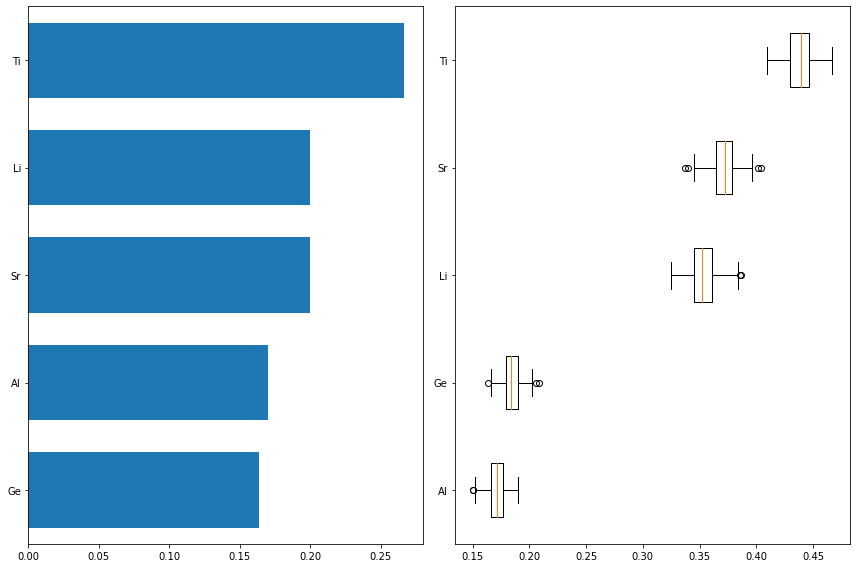

In [6]:
result = permutation_importance(clf, X_train, y_train, n_repeats=100, n_jobs=-1,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

Handling Multicollinear Features
--------------------------------
When features are collinear, permutating one feature will have little
effect on the models performance because it can get the same information
from a correlated feature. One way to handle multicollinear features is by
performing hierarchical clustering on the Spearman rank-order correlations,
picking a threshold, and keeping a single feature from each cluster. First,
we plot a heatmap of the correlated features:



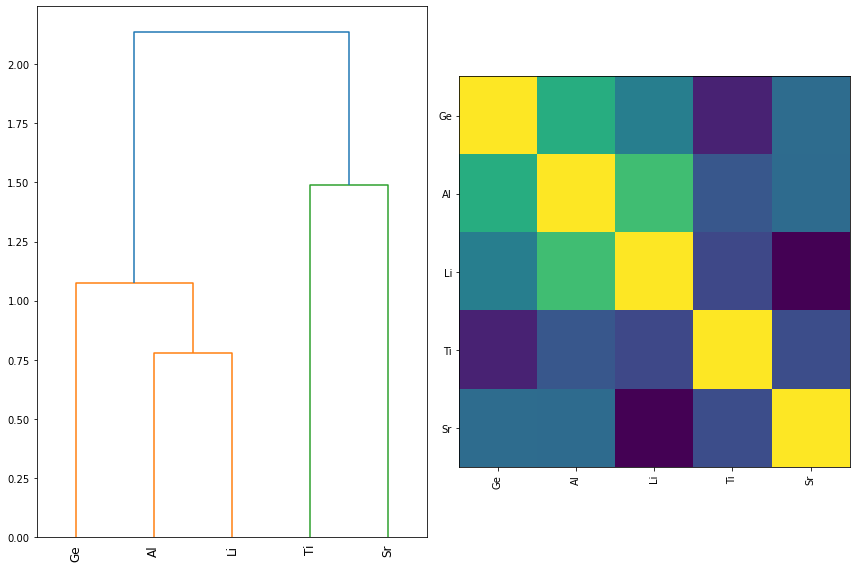

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()
# dendro

Next, we manually pick a threshold by visual inspection of the dendrogram
to group our features into clusters and choose a feature from each cluster to
keep, select those features from our dataset, and train a new random forest.
The test accuracy of the new random forest did not change much compared to
the random forest trained on the complete dataset.



In [9]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance',depth=2)
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features = [1, 2, 3, 4]
print(selected_features)
for i in selected_features:
    print(X.columns[i])

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=200, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))
X_train_sel

[1, 2, 3, 4]
Ti
Li
Ge
Sr
Accuracy on test data with features removed: 0.80


,Ti,Li,Ge,Sr
64,0.180948,32.827867,3.058704,0.007494
1570,0.300000,0.410000,1.050000,0.130000
4217,14.190000,0.530000,1.040000,0.535000
1692,5.670000,270.880000,1.390000,0.028400
2770,9.210000,8.590000,0.810000,0.420000
...,...,...,...,...
3317,1.540000,0.297000,1.440000,0.002000
4167,15.350000,0.390000,1.610000,0.109000
2635,0.800000,63.700000,1.240000,0.030000
4355,24.200000,5.790000,1.900000,0.020000


c:\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


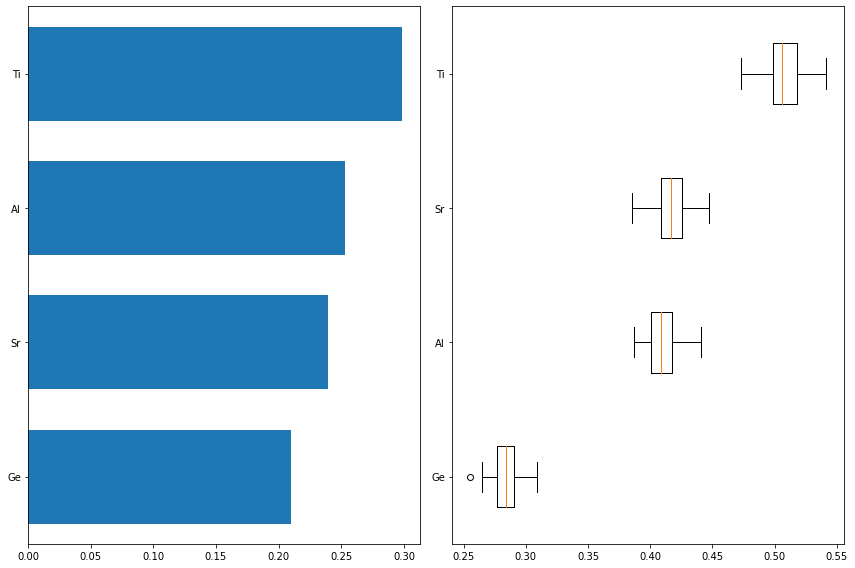

In [10]:
data2 = pd.DataFrame()
data2['feature_names'] = [X.columns[i] for i in selected_features]

result = permutation_importance(clf_sel, X_train_sel, y_train, n_repeats=100,
                                n_jobs=-1, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data2.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data2.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()